In [35]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [36]:
# uvoz podatkov

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)

# preoblikovanje
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


#air_pressure = new_data.drop('WIND_DIRECTION', axis=1, inplace=True)

#print(new_data)
#air_pressure = air_pressure.drop('RAIN_INTENSITY', axis=1, inplace=True)
air_pressure = new_data[['AIR_PRESSURE']]
print(air_pressure)

parameter_type             AIR_PRESSURE
acquisition_timestamp                  
2020-10-13 10:20:00+00:00         952.8
2020-10-13 10:25:00+00:00         952.8
2020-10-13 10:30:00+00:00         952.8
2020-10-13 10:35:00+00:00         952.8
2020-10-13 10:40:00+00:00         952.8
...                                 ...
2023-05-31 21:35:00+00:00         964.8
2023-05-31 21:40:00+00:00         964.8
2023-05-31 21:45:00+00:00         964.9
2023-05-31 21:50:00+00:00         964.9
2023-05-31 21:55:00+00:00         964.9

[271508 rows x 1 columns]


In [37]:
# count the NaN values
nan_count_air_pressure = air_pressure['AIR_PRESSURE'].isna().sum()
print(nan_count_air_pressure)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=air_pressure.index.min(), end=air_pressure.index.max(), freq='5T')
missing_timestamps = complete_range.difference(air_pressure.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

0
5112


276620

In [48]:
# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
air_pressure_incomplete = df_complete_range.merge(air_pressure, left_index=True, right_index=True, how='left')
# print(air_pressure_incomplete)
air_pressure_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
air_pressure_all = air_pressure_incomplete.bfill()
print(air_pressure_all)
air_pressure_all.isna().sum() # okay

str(air_pressure_all.index.dtype) # okay

                           AIR_PRESSURE
2020-10-13 10:20:00+00:00         952.8
2020-10-13 10:25:00+00:00         952.8
2020-10-13 10:30:00+00:00         952.8
2020-10-13 10:35:00+00:00         952.8
2020-10-13 10:40:00+00:00         952.8
...                                 ...
2023-05-31 21:35:00+00:00         964.8
2023-05-31 21:40:00+00:00         964.8
2023-05-31 21:45:00+00:00         964.9
2023-05-31 21:50:00+00:00         964.9
2023-05-31 21:55:00+00:00         964.9

[276620 rows x 1 columns]


'datetime64[ns, UTC]'

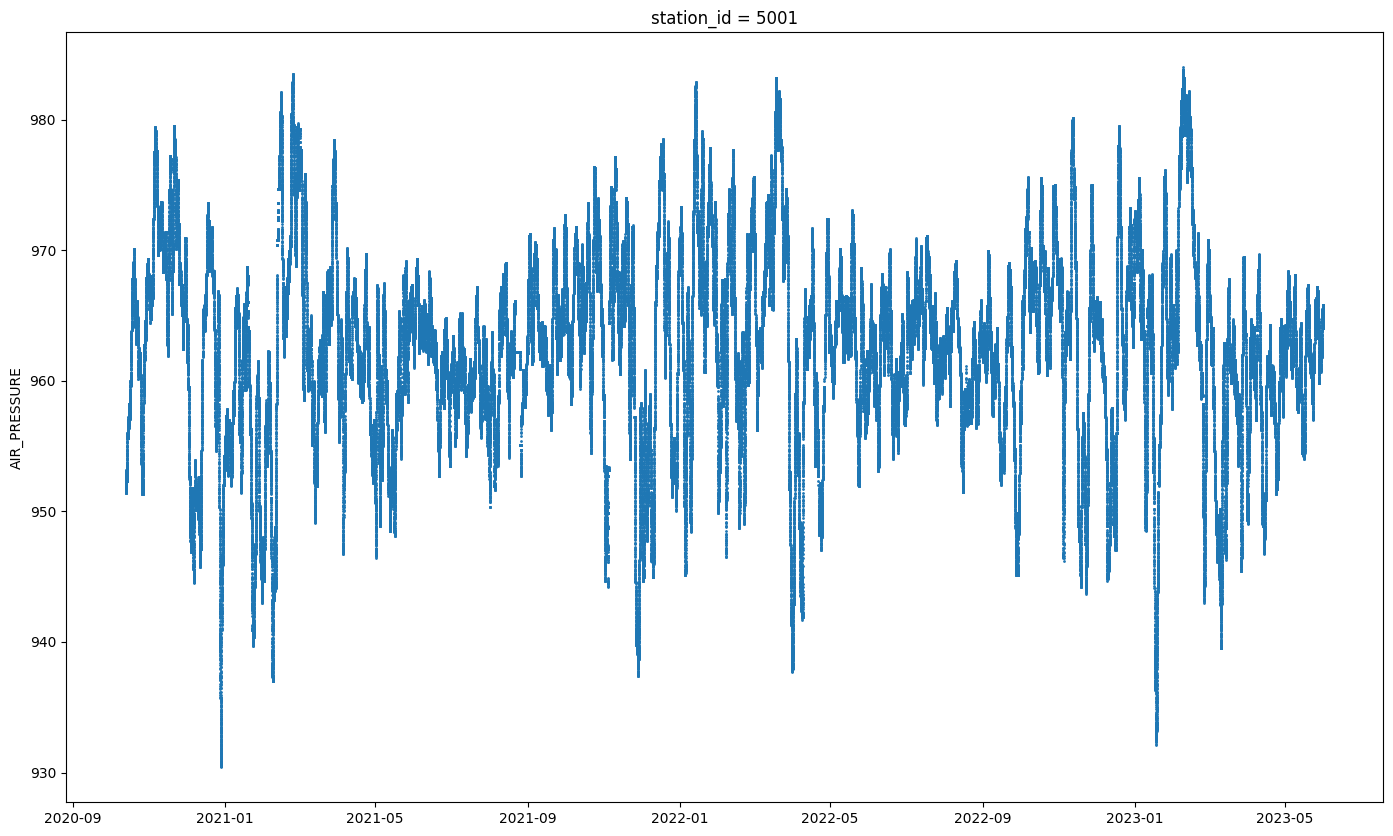

In [50]:
# plot 'AIR_PRESSURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(air_pressure_all.index, air_pressure_all['AIR_PRESSURE'],s=1)
ax.set_ylabel('AIR_PRESSURE')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

In [51]:
air_pressure_20_21 = air_pressure_all.loc[(air_pressure_all.index.year == 2020) | (air_pressure_all.index.year == 2021) , 'AIR_PRESSURE']
print(air_pressure_20_21)

2020-10-13 10:20:00+00:00    952.8
2020-10-13 10:25:00+00:00    952.8
2020-10-13 10:30:00+00:00    952.8
2020-10-13 10:35:00+00:00    952.8
2020-10-13 10:40:00+00:00    952.8
                             ...  
2021-12-31 23:35:00+00:00    968.9
2021-12-31 23:40:00+00:00    968.8
2021-12-31 23:45:00+00:00    968.9
2021-12-31 23:50:00+00:00    968.9
2021-12-31 23:55:00+00:00    969.0
Freq: 5T, Name: AIR_PRESSURE, Length: 128036, dtype: float64


In [ ]:
# hourly data
# sum the values for each hour and take the mean

air_pressure_20_21_hourly = air_pressure_20_21['AIR_PRESSURE'].resample('H').mean()

### Statyonarity

We will check the stationarity of the data with two tests: ADF (Augmented Dickey-Fuller) and KPSS (Kwiatkowski-Phillips-Schmidt-Shin). For further analysis it would be good if the data was stationary. Stationarity indicates that the statistical properties of the data do not change over time (the time series does not have a time-dependent structure).

ADF yes, KPSS yes: statyonary

ADF no, KPSS no: non-stationary

ADF no, KPSS yes: trend stationary (remove the trend and check again)

ADF yes, KPSS no: difference stationary (differencing needs to be used and then check again)

(naredi oba)

(v porocilu napisi vec o stacionarnosti in testih, stationary = without trend and seasonal components)

Types of Stationary Series

Strict Stationary – Satisfies the mathematical definition of a stationary process. Mean, variance & covariance are not a function of time.

Seasonal Stationary – Series exhibiting seasonality.

Trend Stationary – Series exhibiting trend.

Note: Once the seasonality and trend are removed, the series will be strictly stationary.

In [52]:
# Augmented Dickey-Fuller (ADF) test for testing the stationarity of the data

import statsmodels
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC') # AIC = Akaike Information Criterion
     print("1. ADF : ",dftest[0])
     print("2. p-value : ", dftest[1]) # indicates the probability that the series has a unit root (is non-stationary)
     print("3. Number Of Lags : ", dftest[2]) # the number of lags used in the regression when determining the test statistic
     print("4. Number of observations used For ADF regression:",      dftest[3])
     print("5. critical values :" ) # critical values of the test statistic at the 1%, 5% and 10% levels
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(air_pressure_20_21)

1. ADF :  -6.354976948153196
2. p-value :  2.555985376375562e-08
3. Number Of Lags :  63
4. Number of observations used For ADF regression: 127972
5. critical values :
	 1% :  -3.430401100484279
	 5% :  -2.8615625856678637
	 10% :  -2.5667820215511994


#### Interpretation of the ADF test:

Null hypothesis: Time series has a unit root, meaning it is non-stationary. Options: reject and not reject. We want to reject

The ADF test gives a test statistic, a p-value, and critical values at different significance levels.
ADF: has to be more negative than critical levels to reject the null hypothesis at those levels of confidence (and it is)

p < 0.05 - also rejects the null hypothesis

According to the ADF test the data is likely stationary.

In [53]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for testing the stationarity of the data¸

from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test statistic','p-value','Number of lags used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical value (%s)'%key] = value
    print (kpss_output)
kpss_test(air_pressure_20_21)

Results of KPSS Test:
Test statistic             0.442552
p-value                    0.058814
Number of lags used      205.000000
Critical value (10%)       0.347000
Critical value (5%)        0.463000
Critical value (2.5%)      0.574000
Critical value (1%)        0.739000
dtype: float64


#### Interpretation of the KPSS test:

Null Hypothesis: Series is trend stationary or series has no unit root. Options: reject and not reject. We want to not reject it.

The KPSS test gives a test statistic, a p-value, and critical values at different significance levels.
Test statistic has to be less than critical value to be rejected at that level.

p < 0.05 - doesnt reject the null hypothesis

10% rejects
5% doesn't reject
2.5% doesn't reject
1% doesn't reject

Test statistic exceeds the critical value at the level of 10%. p-value is more than than 0.05. To be safe, we will rather assume that there is some evidence of trend-statyonarity.

According to the KPSS test the data is likely non-stationary. 

This contradicts the result of ADF test.

It is likely trend-stationary. Let's remove the trend and check again. Removing the trend can be done by differencing.

In [54]:
# differencing
air_pressure_20_21_diff = air_pressure_20_21.diff().dropna()

In [55]:
# ADF on the differenced data
ad_test(air_pressure_20_21_diff)

1. ADF :  -35.77909789019013
2. p-value :  0.0
3. Number Of Lags :  62
4. Number of observations used For ADF regression: 127972
5. critical values :
	 1% :  -3.430401100484279
	 5% :  -2.8615625856678637
	 10% :  -2.5667820215511994


In [56]:
# KPSS on the differenced data
kpss_test(air_pressure_20_21_diff)

Results of KPSS Test:
Test statistic             0.008826
p-value                    0.100000
Number of lags used      173.000000
Critical value (10%)       0.347000
Critical value (5%)        0.463000
Critical value (2.5%)      0.574000
Critical value (1%)        0.739000
dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_22324\1187817762.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


ADF and KPSS both suggest the differenced data is stationary so we can proceed with fitting the models and forecasting.

In [57]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(air_pressure_20_21, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-283693.750, Time=141.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-272356.369, Time=22.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-273879.399, Time=16.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-273585.915, Time=21.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-272358.075, Time=8.91 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-283022.503, Time=114.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-282255.424, Time=155.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-283837.787, Time=134.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-282674.580, Time=141.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-283841.935, Time=201.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-282577.865, Time=177.58 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-283917.921, Time=252.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-283381.298, Time=209.69 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : A